In [165]:
# Import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Import the data
data_in = pd.read_csv("winequality-red.csv")
Random_state=42

## Description of features:

* Fixed acidity: Acidity is the main source of the taste of wine. Fixed acids are the acids that are definitely supposed to be there. High fixed acidity makes for a stronger-tasting wine. Recently, wines with lower acidity and a more balanced, subtle flavor have been getting the best reviews.

* Volatile acidity: This kind of acidity may or may not be purposeful. These acids include naturally occuring vinegar (which apparently is sometimes a good thing) and ethyl acetate (nail polish remover) that is not a good thing.

* Residual sugar: Residual sugar of course indicates sweetness. In the US, sugar is sometimes added after fermentation to make wine sweeter, but this is not a common practice in other countries. It is actually illegal in some places. However, most sugar is added BEFORE fermentation so that the yeast and bacteria can do a better job. When the fermentation process is stopped prematurely, there will be a lot of residual sugar left over. Cheap wines tend to have high sugar content.

* Chloride: Neutralizes acid. This might be used to rein in volatile acidity. It naturally comes from the grapes and the soil in which they are grown. Higher chloride count means the grape juice spent more time in contact with the skins and seeds and stems of the grapes. Chloride can also lead to a salty flavor in the wine. French soil naturally has a low chloride count. Then the USA, then South Africe, then Chile, Argentina, and Australia. Australia has some major variation in soil chloride content.

* Sulfur Dioxide: There is a new movement in wine-making to avoid adding sulfur dioxide. It was originally started as a way to prevent oxidation and microbrial infection of wine, a preservative. However, it also makes the wine more consistent. Free sulfur dioxide can create a bitter, metallic flavor, and so it is often filtered out.

* Density: This is used to measure the alcohol content of wine. The simple formula to get the alcohol content from the change in wine density is: $Alc = \frac{D_0 - D_f}{7.362}$

* PH: The total acidity of the wine. Lower $\implies$ stronger tasting, Higher $\implies$ softer finish.

* Sulphates: Sulfur-related waste. This is where the added sulfur dioxide attaches to things and creates some pretty gross-sounding compounds. These chemicals are often found in dish soap, epsom salts, and household cleaners. However, they are also used by beer makers as Brewer's Gypsum, to fix problems with water-quality.

* Alcohol: High alcohol $\implies$ bold flavor, low alcohol $\implies$ lighter body. 

Engineered Features:

* **vol_fixed_ratio** is the ratio of volatile acids to fixed acids, $\frac{VA}{FA}$

* **prop_citric_acid** is the proportion of fixed acid that is citric acid, $\frac{CA}{FA}$

* **sugar_acidity_ratio** is the ratio of residual sugar to ph, $\frac{sugar}{ph}$, **sugar_acidity_interaction** is the residual sugar times the ph, $sugar\times ph$

* **chlor_acid_ratio** is the ratio of chlorides to ph, $\frac{chlor}{ph}$, **chlor_fixed_ratio** is the ratio of chlorides to fixed acidity, $\frac{chlor}{FA}$, **chlor_vol_ratio** is the ratio of chlorides to volatile acidity, $\frac{chlor}{VA}$

* **prop_free_sulfur** is the proportion of sulfur dioxide that is free, $\frac{FSO_2}{TSO_2}$

* **starting_density** is the density of the grape juice before fermentation, $SD = \frac{(Alc\times 7.362 + (density\times 1000)}{1000}$


In [166]:
data_in['vol_fixed_ratio'] = data_in['volatile acidity'] / data_in['fixed acidity']
data_in['prop_citric_acid'] = data_in['citric acid'] / data_in['fixed acidity']
data_in['sugar_acidity_ratio'] = data_in['residual sugar'] / data_in['pH']
data_in['sugar_acidity_interaction'] = data_in['residual sugar'] * data_in['pH']
data_in['chlor_acid_ratio'] = data_in['chlorides'] / data_in['pH']
data_in['chlor_fixed_ratio'] = data_in['chlorides'] / data_in['fixed acidity']
data_in['chlor_vol_ratio'] = data_in['chlorides'] / data_in['volatile acidity']
data_in['prop_free_sulfur'] = data_in['free sulfur dioxide'] / data_in['total sulfur dioxide']
data_in['starting_density'] = (data_in['alcohol']*7.362 + data_in['density']*1000)/1000

In [167]:
y=data_in['quality']
X=data_in.drop(['quality'], axis=1)

In [168]:
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25)

In [169]:
modelOne = Pipeline([
    ('scaler', MinMaxScaler()),
    ('kbest', SelectKBest(chi2, k=11)),
    ('pca', PCA(n_components=10, whiten=True)),
    ('poly', PolynomialFeatures(degree=2)),
    ('svc', SVC(C= 10, decision_function_shape='ovo', kernel='poly', degree=3, coef0=1))   
])
hyperGrid = {}#many things used to be here
GridS=GridSearchCV(modelOne,hyperGrid,cv=5)
GridSearch = GridS.fit(XTrain,yTrain)
yPredict = GridS.predict(XTrain)
yPredictTrain = GridS.predict(XTrain)
yPredictTest = GridS.predict(XTest)
print("Training data", f1_score(yTrain, yPredictTrain, average='weighted'))
print("Test data", f1_score(yTest, yPredictTest, average='weighted'))

Training data 0.8595755233159108
Test data 0.610538852382349


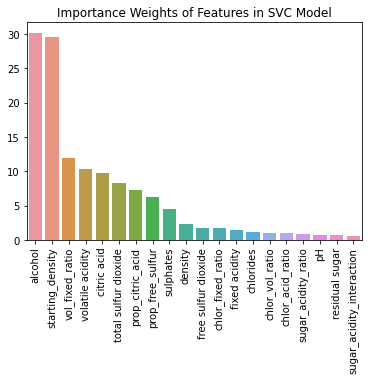

In [170]:
# Checking feature importance from SelectKBest
kbest = GridSearch.best_estimator_.steps[1][1]
importance_scores = pd.Series(kbest.scores_).sort_values(ascending=False)
important_features = XTrain.columns[importance_scores.index]
plot = sns.barplot(x=important_features, y=importance_scores)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title('Importance Weights of Features in SVC Model');

In [171]:
print(classification_report(yTrain, yPredict, target_names=['3', '4', '5', '6', '7', '8']))

              precision    recall  f1-score   support

           3       1.00      0.75      0.86         8
           4       1.00      0.66      0.79        41
           5       0.86      0.89      0.88       505
           6       0.82      0.86      0.84       473
           7       0.94      0.83      0.88       157
           8       1.00      0.67      0.80        15

    accuracy                           0.86      1199
   macro avg       0.94      0.78      0.84      1199
weighted avg       0.86      0.86      0.86      1199



In [172]:
yPredict = GridS.predict(XTest)
print(classification_report(yTest, yPredict))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        12
           5       0.67      0.71      0.69       176
           6       0.60      0.58      0.59       165
           7       0.62      0.60      0.61        42
           8       0.00      0.00      0.00         3

    accuracy                           0.61       400
   macro avg       0.32      0.31      0.31       400
weighted avg       0.61      0.61      0.61       400



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Training Data Results - No target binning')

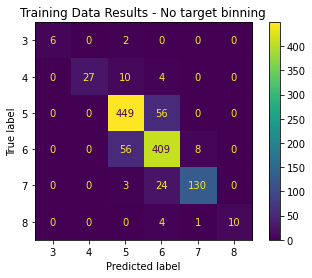

In [173]:
plot_confusion_matrix(GridSearch,XTrain, yTrain)
plt.title("Training Data Results - No target binning")

Text(0.5, 1.0, 'Test Data Results - No target binning')

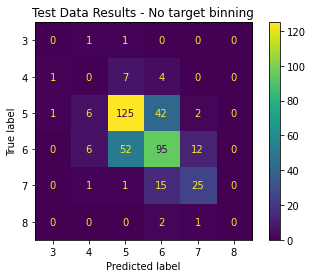

In [174]:
plot_confusion_matrix(GridSearch,XTest, yTest)
plt.title("Test Data Results - No target binning")

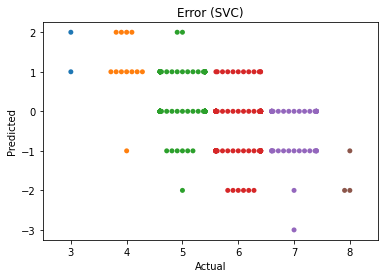

In [175]:
# Making a jittered scatterplot of residuals
pred = GridSearch.predict(XTest)
err = pred - yTest
#sns.scatterplot(x=range(len(err)), y=err)
sns.swarmplot(x=yTest, y=err)
plt.title('Error (SVC)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('res_plot_svc')
plt.show()

Here we tried binning the Target Values (the Quality feature, y).  We used the transformation yBin=np.floor((y - 3) / 2) which would combine qualities 3 and 4 (low quality), 5 and 6 (average quality), and 7 and 8 (high quality).  We did this because there were so few instances in the lower and high quality sections.

In [176]:
data_in = pd.read_csv("winequality-red.csv")
data_in['vol_fixed_ratio'] = data_in['volatile acidity'] / data_in['fixed acidity']
data_in['prop_citric_acid'] = data_in['citric acid'] / data_in['fixed acidity']
data_in['sugar_acidity_ratio'] = data_in['residual sugar'] / data_in['pH']
data_in['sugar_acidity_interaction'] = data_in['residual sugar'] * data_in['pH']
data_in['chlor_acid_ratio'] = data_in['chlorides'] / data_in['pH']
data_in['chlor_fixed_ratio'] = data_in['chlorides'] / data_in['fixed acidity']
data_in['chlor_vol_ratio'] = data_in['chlorides'] / data_in['volatile acidity']
data_in['prop_free_sulfur'] = data_in['free sulfur dioxide'] / data_in['total sulfur dioxide']
data_in['starting_density'] = (data_in['alcohol']*7.362 + data_in['density']*1000)/1000
y=data_in['quality']
#here is the bin transformation
yBin=np.floor((y - 3) / 2)
X=data_in.drop(['quality'], axis=1)
XTrain, XTest, yTrain, yTest = train_test_split(X, yBin, test_size = 0.25)
modelOne = Pipeline([
    ('scaler', MinMaxScaler()),
    ('kbest', SelectKBest(chi2, k=11)),
    ('pca', PCA(n_components=10, whiten=True)),
    ('poly', PolynomialFeatures(degree=2)),
    ('svc', SVC(C= 10, decision_function_shape='ovo', kernel='poly', degree=3))   
])
GridS=GridSearchCV(modelOne,hyperGrid,cv=5)
GridSearch = GridS.fit(XTrain,yTrain)
yPredictTrain = GridS.predict(XTrain)
yPredictTest = GridS.predict(XTest)
yPredict = GridS.predict(XTest)
print("Training data", f1_score(yTrain, yPredictTrain, average='weighted'))
print("Test data", f1_score(yTest, yPredictTest, average='weighted'))

Training data 0.8957613110323023
Test data 0.8249930366790834


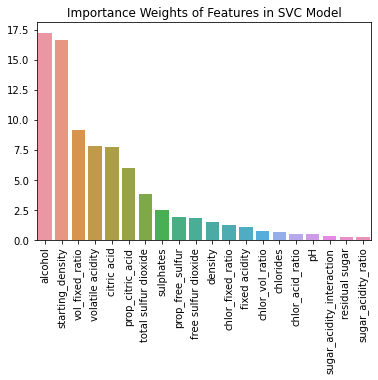

In [177]:
# Checking feature importance from SelectKBest
kbest = GridSearch.best_estimator_.steps[1][1]
importance_scores = pd.Series(kbest.scores_).sort_values(ascending=False)
important_features = XTrain.columns[importance_scores.index]
plot = sns.barplot(x=important_features, y=importance_scores)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title('Importance Weights of Features in SVC Model');

Text(0.5, 1.0, 'Test Data Results - Target binning')

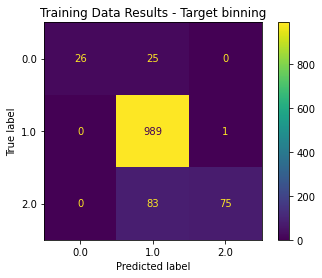

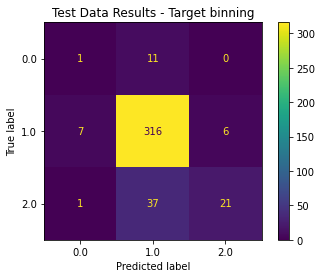

In [178]:
plot_confusion_matrix(GridSearch,XTrain, yTrain)
plt.title("Training Data Results - Target binning")
plot_confusion_matrix(GridSearch,XTest, yTest)
plt.title("Test Data Results - Target binning")

The team can use regularization to get a better fit, but then the model only guesses "average" (category 1) for all wines.  Since the data has such thin tails the score goes up, but it never predicts any low or high values. As such, it seems like binning raises the score simple by removing punishment for adjacency errors for categories 5 and 6 of the regular data.